## Setup and imports

In [1]:
%load_ext autoreload
%autoreload 2


In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

from tf_tabular.builder import InputBuilder
from tf_tabular.utils import get_vocab
from tf_tabular.numeric_processor import NumericProcessor

## Helper functions

In [5]:
def preprocess_titanic(df):
    df['no_cabin'] = df['Cabin'].isna()
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
    return df

def build_vocabs(df, categoricals):
    vocabs = {}
    for cat in categoricals:
        vocabs[cat] = get_vocab(df[cat], 10)
    return vocabs

def build_norm_params(df, numerics):
    norm_params = {}
    for num in numerics:
        norm_params[num] = {'mean': df[num].mean(), 'var': df[num].var()}
    return norm_params

def split_dataset(df, categoricals, numericals, target='Survived', frac=0.8):
    df = df[categoricals + numericals + [target]]
    msk = np.random.rand(len(df)) < frac
    train_df = df[msk]
    val_df = df[~msk]
    return train_df, val_df

## Load dataset

In [6]:
df = pd.read_csv('titanic.csv')

## Some insights into the data

In [7]:
df.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [8]:
display(df.groupby('Survived').count())
display(df.groupby('Survived').count()['PassengerId'] / len(df))

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,,
0,549,549,549,549,424,549,549,549,549,68,549
1,342,342,342,342,290,342,342,342,342,136,340


Survived
0    0.616162
1    0.383838
Name: PassengerId, dtype: float64

In [9]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Data preprocessing

In [10]:
df = preprocess_titanic(df)

### Select columns and compute parameters

In [11]:
categoricals = ['Pclass', 'Sex', 'no_cabin']
numericals = ['Age', 'Fare', 'SibSp', 'Parch']
embedding_dims = {'Pclass': 4, 'Sex': 4, 'no_cabin': 2}

vocabs = build_vocabs(df, categoricals)
norm_params = build_norm_params(df, numericals)

### Split dataswet into train and test

In [12]:
train_df, val_df = split_dataset(df, categoricals, numericals)

train_ds = tf.data.Dataset.from_tensor_slices((train_df.to_dict('list'), train_df['Survived']))
val_ds = tf.data.Dataset.from_tensor_slices((val_df.to_dict('list'), val_df['Survived']))

## Model training

### Build model using tf_tabular


In [13]:
def build_model():
    input_builder = InputBuilder(numeric_processor=NumericProcessor(num_projection=8, cross_features=False))
    input_builder.add_inputs_list(categoricals=categoricals, numericals=numericals,
                                  normalization_params=norm_params, vocabs=vocabs,
                                  embedding_dims=embedding_dims)
    inputs, output = input_builder.build_input_layers()
    x = Dense(32, activation='relu')(output)
    x = Dense(1, activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=x)

model = build_model()

### Compile and fit

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds.batch(32), validation_data=val_ds.batch(32), epochs=75, verbose=0)

/Users/mathias/miniforge3/envs/tftab/lib/python3.10/site-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['Survived'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


### Analyze metrics

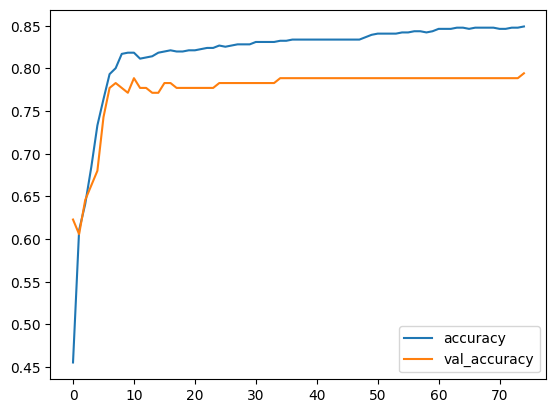

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

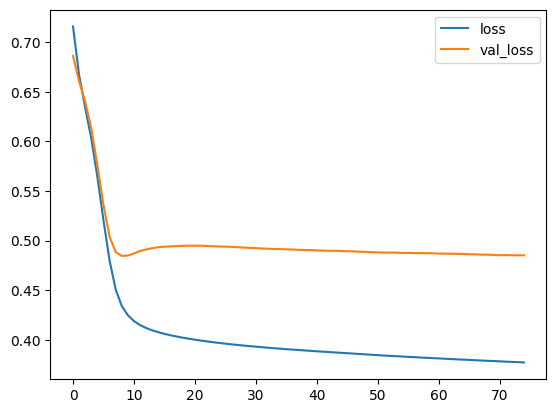

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()